In [133]:
from matplotlib import pyplot as plt
import numpy as np
import shutil
import tensorflow as tf
print(tf.__version__)

1.6.0


### Download and explore MNIST data

In [2]:
data = tf.keras.datasets.mnist.load_data(path='mnist.npz') 
# Tuple of Numpy arrays: ((x_train, y_train), (x_test, y_test))

11493376/11490434 [==============================]11493376/11490434 [==============================] - 3s 0us/step



In [60]:
x = data[0][0] #60K 28x28 images
y = data[0][1]
x_test = data[1][0] #10K 28x28 images
y_test = data[1][1]

Show amount of data

In [61]:
print('x:{}'.format(x.shape))
print('y:{}'.format(y.shape))
print('x_test:{}'.format(x_test.shape))
print('y_test:{}'.format(y_test.shape))

x:(60000, 28, 28)
y:(60000,)
x_test:(10000, 28, 28)
y_test:(10000,)


Split into x and y into 80% train and 20% eval.

We'll save x_test and y_test as our hold out data

In [157]:
# Split into train and eval
msk = np.random.rand(len(x)) < 0.8 #numpy vector of booleans
x_train = x[msk] #can use an numpy vector to filter a matrix
y_train = y[msk]
x_eval = x[~msk]
y_eval = y[~msk]
print('x_train:{}'.format(x_train.shape))
print('y_train:{}'.format(y_train.shape))
print('x_eval:{}'.format(x_eval.shape))
print('y_eval:{}'.format(y_eval.shape))
print('x_test:{}'.format(x_test.shape))
print('y_test:{}'.format(y_test.shape))

x_train:(48009, 28, 28)
y_train:(48009,)
x_eval:(11991, 28, 28)
y_eval:(11991,)
x_test:(10000, 28, 28)
y_test:(10000,)


Display one training example

Label:4


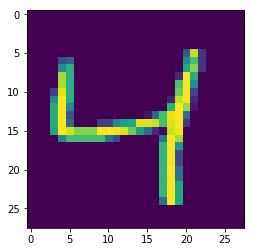

In [159]:
example = 1 #try changing this to see new data
print('Label:{}'.format(y_train[example]))
plt.imshow(x_train[example])
plt.show()

### Define input functions

In [180]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train.astype('float32')}, #TODO: figure out why this needs to be float32. float16 spins forever, int gives error
    y=y_train.astype('int32'),
    batch_size=100,
    num_epochs=None, #can i change this to 1 and specify epochs at train time?
    shuffle=True)

In [181]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_eval.astype('float32')},
    y=y_eval.astype('int32'),
    num_epochs=1,
    shuffle=False)

### Define model function

In [183]:
#Implementation from: https://www.tensorflow.org/tutorials/layers#building_the_cnn_mnist_classifier
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.expand_dims(features["x"], -1)

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training= (mode == tf.estimator.ModeKeys.TRAIN))

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  if mode == tf.estimator.ModeKeys.EVAL:
      eval_metric_ops = {
          "accuracy": tf.metrics.accuracy(
              labels=labels, predictions=predictions["classes"])}
      return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Instantiate Estimator

In [184]:
OUTDIR = "trained_custom"
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir=OUTDIR)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'trained_custom', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x120fc4f98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train and Eval

In [185]:
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=50) #example uses 20000
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into trained_custom/model.ckpt.
INFO:tensorflow:loss = 43.540283, step = 1
INFO:tensorflow:Saving checkpoints for 50 into trained_custom/model.ckpt.
INFO:tensorflow:Loss for final step: 1.2389966.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-16-02:57:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from trained_custom/model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-16-02:57:49
INFO:tensorflow:Saving dict for global step 50: accuracy = 0.8248687, global_step = 50, loss = 0.5431505
{'accuracy': 0.8248687, 'loss': 0.5431